# Описание набора данных
Эта база данных была создана для идентификации голоса как мужского или женского на основе акустических свойств голоса и речи. Набор данных состоит из 3168 записанных образцов голоса, полученных от говорящих мужчин и женщин. Образцы голоса предварительно обрабатываются акустическим анализом в R с использованием пакетов seewave и tuneR с анализируемым частотным диапазоном 0–280 Гц (диапазон человеческого голоса).

Признак  | Описание
-------------------|--------------------
meanfreq| средняя частота (в кГц)
sd| стандартное отклонение частоты
median| средняя частота (в кГц)
Q25| первый квантиль (в кГц)
Q75| третий квантиль (в кГц)
IQR| межквантильный диапазон (в кГц)
skew| асимметрия (см. примечание в описании specprop)
kurt| эксцесс (см. примечание в описании specprop)
sp.ent| спектральная энтропия
sfm| спектральная плоскостность
mode| частота режима
centroid| центроид частоты (см. specprop)
peakf| пиковая частота (частота с наибольшей энергией)
meanfun| среднее значение основной частоты, измеренное по акустическому сигналу
minfun| минимальная основная частота, измеренная по акустическому сигналу.
maxfun| максимальная основная частота, измеренная по акустическому сигналу.
meandom| среднее значение доминирующей частоты, измеренное по акустическому сигналу.
mindom| минимум доминирующей частоты, измеренный по акустическому сигналу
maxdom| максимальная доминирующая частота, измеренная по акустическому сигналу.
dfrange| диапазон доминирующей частоты, измеренный по акустическому сигналу.
modinx| индекс модуляции. Рассчитывается как накопленная абсолютная разность между соседними измерениями основных частот, деленная на частотный диапазон.
label| мужчина или женщина





# Загрузка и предварительная обработка данных

Импортируем библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

Загрузим данные в датафрейм

In [2]:
df = pd.read_csv('/content/voice.csv')

Убедимся, что данные загружены корректно

In [3]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


Окинем взглядом основные статистики, посчитанные по данному набору данных.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

1. Характеристики голоса: Датасет содержит 3168 записей голоса, включающих акустические свойства голоса, такие как частота, амплитуда, частотные характеристики и т.д.
2. Целевая переменная (label): Пол говорящего (мужской или женский)

In [6]:
#Статистика
df.describe().round().T

,count,mean,std,min,25%,50%,75%,max
meanfreq,3168.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sd,3168.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median,3168.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q25,3168.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q75,3168.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IQR,3168.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
skew,3168.0,3.0,4.0,0.0,2.0,2.0,3.0,35.0
kurt,3168.0,37.0,135.0,2.0,6.0,8.0,14.0,1310.0
sp.ent,3168.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
sfm,3168.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


1. count - количество наблюдений
2. mean - среднее значение
3. std - стандартное отклонение
4. min - минимальное значение
5. max - максимальное значение
6. 25% - нижний процентиль
7. 50% - медиана
8. 75% - верхний процентиль

#Визуализация набора данных
Определим соотношение мужчин и женщин, участвующих в исследовании

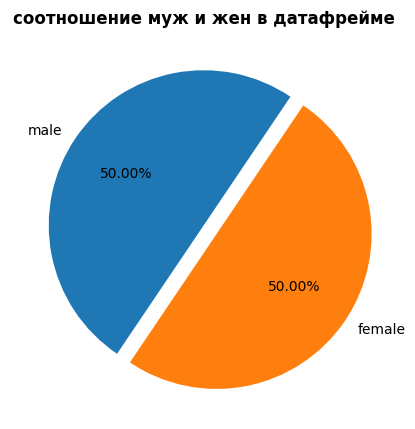

In [47]:
plt.figure(figsize=(5,7))
plt.title("соотношение муж и жен в датафрейме",fontweight="bold")
values = df["label"].value_counts()
plt.pie(values, labels=["male","female"], explode=(0,0.1), autopct="%.2f%%", startangle=56)
plt.show()

Имеем сбалансированный по полу датафрейм

Meanfun (среднее значение основной частоты) ещё один показатель пола голоса с порогом в 140 Гц, отделяющим мужские и женские классификации

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)


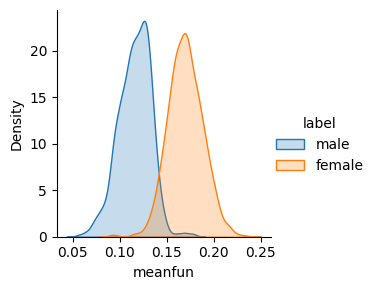

In [16]:
fig = sns.FacetGrid(df, hue="label")
fig.map(sns.kdeplot, "meanfun", shade=True)
fig.add_legend()

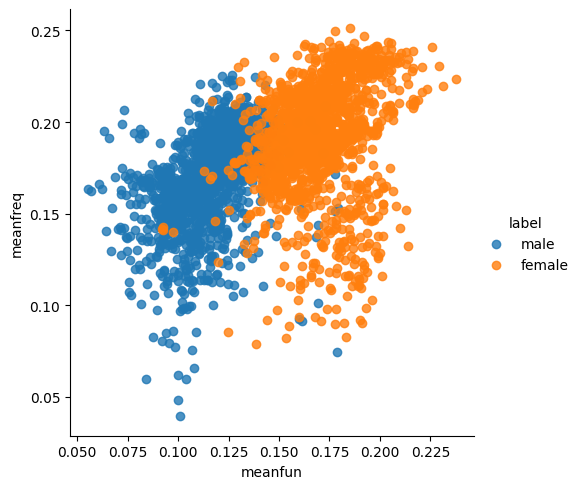

In [8]:
sns.lmplot(x='meanfun',y='meanfreq',hue='label',data=df,fit_reg=False)

# Постановка задачи и построение модели

Наша задача состоит в создании модели машинного обучения, способной классифицировать голоса на мужские и женские на основе их акустических свойств

#Подготовка данных

In [31]:
#Отбор данных для предикторов, удаление столбца label
X=df.drop(['label'],axis=1)
X.shape

(3168, 20)

In [32]:
#Отбор столбца label для отклика
y=df['label']
y.shape

(3168,)

In [33]:
#Заменим значения столбца label на числовые - male(мужчины) присвоим 0, female(женщины) присвоим 1
y=y.map({'male':0,'female':1})

Делим набор данных на обучающую и тестовую часть

In [34]:
# Разделение на обучающую и тестовую выборки
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0, stratify=y)

In [35]:
# Масштабирование признаков
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

#Использование различных моделей классификации

Построим классификатор на основе логистической регрессии

In [36]:
# Обучение модели логистической регрессии
linear_model = LogisticRegression(max_iter=1000)
linear_model.fit(X_train,y_train)
# Предсказание классов на тестовых данных
y_linear_model = linear_model.predict(X_test)
# Оценка качества модели
score_linear_model = round(accuracy_score(y_linear_model,y_test)*100, 3)
print('Точность модели:',score_linear_model,"%")
print("\nОтчет о классификации: \n",classification_report(y_linear_model,y_test))

Точность модели: 97.634 %

Отчет о классификации: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       322
           1       0.97      0.98      0.98       312

    accuracy                           0.98       634
   macro avg       0.98      0.98      0.98       634
weighted avg       0.98      0.98      0.98       634



Построим классификатор на основе метода ближайших соседей k-NN

In [37]:
# Обучение модели k-ближайших соседей
KNNModel = KNeighborsClassifier(n_neighbors=3)
KNNModel.fit(X_train,y_train)
# Предсказание классов на тестовых данных для kNN
y_KNNModel = KNNModel.predict(X_test)
# Оценка качества модели
score_KNNModel = round(accuracy_score(y_KNNModel,y_test)*100, 3)
print('Точность модели:',score_KNNModel,"%")
print("\nОтчет о классификации: \n",classification_report(y_KNNModel,y_test))

Точность модели: 98.423 %

Отчет о классификации: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       321
           1       0.98      0.99      0.98       313

    accuracy                           0.98       634
   macro avg       0.98      0.98      0.98       634
weighted avg       0.98      0.98      0.98       634



Построим классификатор на основе Дерева принятия решений

In [38]:
# Обучение модели дерева принятия решений
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,y_train)
# Предсказание классов на тестовых данных для дерева принятия решений
y_dt = dt_model.predict(X_test)
# Оценка качества модели
score_dt = round(accuracy_score(y_test,y_dt)*100, 3)
print("Точность модели: ",score_dt,"%")
print("\nОтчет о классификации: \n",classification_report(y_test,y_dt))

Точность модели:  96.688 %

Отчет о классификации: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       317
           1       0.97      0.96      0.97       317

    accuracy                           0.97       634
   macro avg       0.97      0.97      0.97       634
weighted avg       0.97      0.97      0.97       634



#Оценка модели и результатов

Анализ производительности моделей

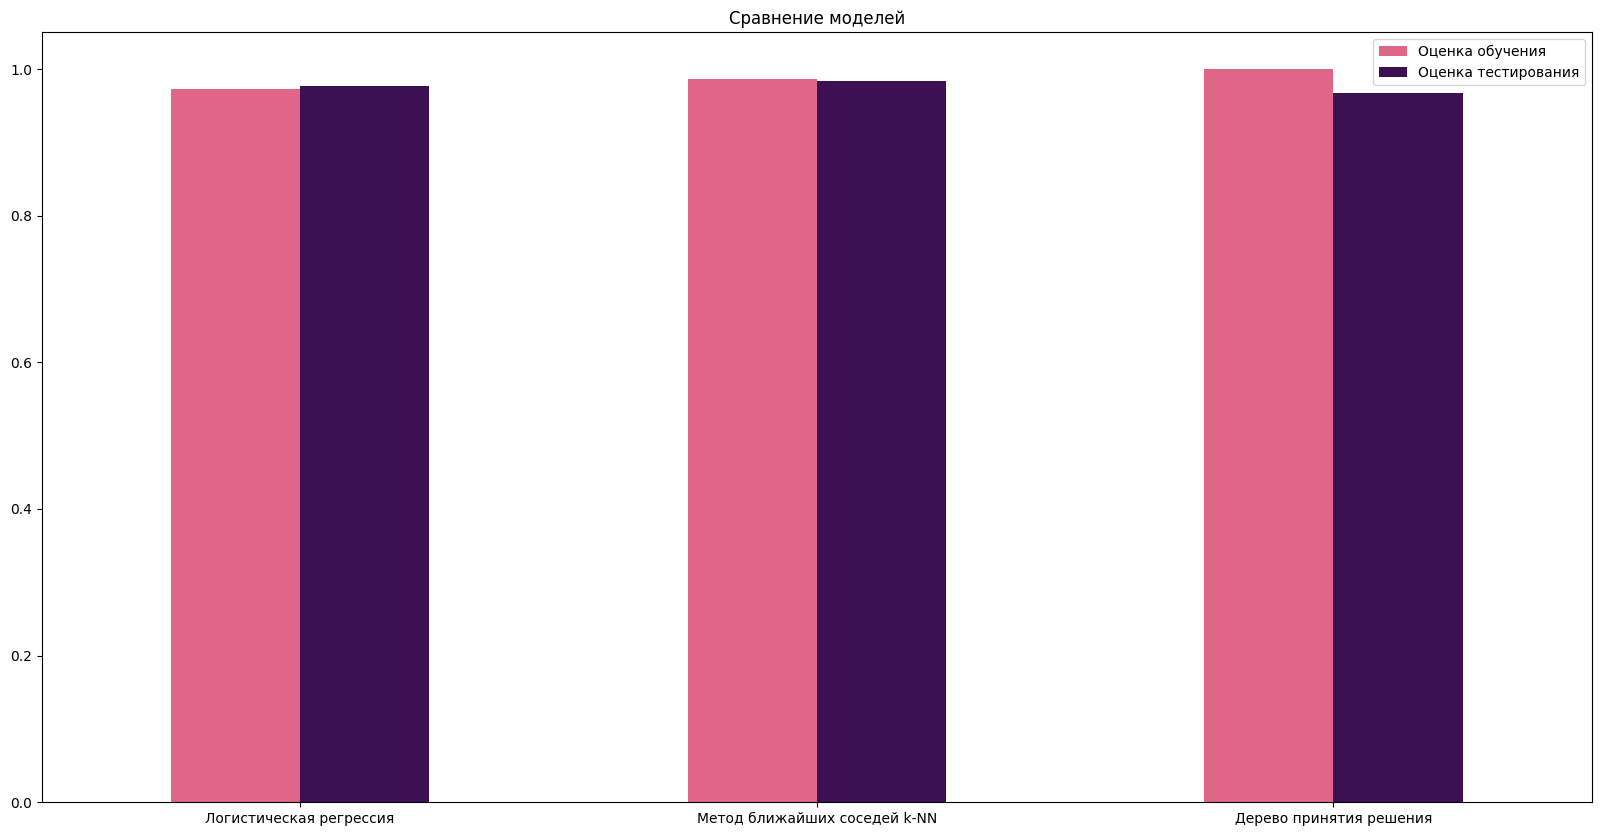

In [43]:
trainScores = [linear_model.score(X_train,y_train), KNNModel.score(X_train,y_train), dt_model.score(X_train,y_train)]
testScores = [linear_model.score(X_test,y_test), KNNModel.score(X_test,y_test), dt_model.score(X_test,y_test)]
indices = ['Логистическая регрессия', 'Метод ближайших соседей k-NN', 'Дерево принятия решения']
scores = pd.DataFrame({'Оценка обучения': trainScores,'Оценка тестирования': testScores}, index=indices)
plot = scores.plot.bar(figsize=(20, 10), rot=0, color=['#df6589ff', '#3c1053ff'])
plt.title('Сравнение моделей')
plt.show()

In [44]:
scores

,Оценка обучения,Оценка тестирования
Логистическая регрессия,0.973165,0.976341
Метод ближайших соседей k-NN,0.986582,0.984227
Дерево принятия решения,1.000000,0.966877


#Вывод
На основании проведенного анализа можно сделать вывод, что метод ближайших соседей k-NN показывают более устойчивое поведение и лучшую обобщающую
способность по сравнению с другими обученными моделями. Именно его стоит использовать для прогнозирования пола (мужской или женский) на основе различных акустических параметров.